# Education and GDP

### The purpose of this project is to determine whether a relationship exists between educational attainment and GDP.

In [1]:
# import packages
from bs4 import BeautifulSoup
import requests
import pandas as pd
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns # try to install seaborn from home
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
import numpy as np

%matplotlib inline  

# try to use fuzzywuzzy package if you have time to improve matching on country name between GDP and UN datasets
#from fuzzywuzzy import fuzz 
#from fuzzywuzzy import process

## Data Preparation

In [2]:
url = "http://web.archive.org/web/20110514112442/http://unstats.un.org/unsd/demographic/products/socind/education.htm"
r = requests.get(url)
data = r.text
soup = BeautifulSoup(r.content)

In [3]:
table = soup.find_all('table')[6]
header_html = table.find(class_='lheader').find_all('td')
column_names = [c.text for c in header_html if len(c.text) > 0]
rows = table.find_all('tr', {'class': 'tcont'}) 
cells = [[c.text for c in row.find_all('td')] for row in rows]

In [4]:
countries_df = pd.DataFrame(cells)
cleaned_df = countries_df.drop([2, 3, 5, 6, 8, 9, 11], axis=1)
cleaned_df.columns = column_names
cleaned_df = cleaned_df[cleaned_df.Total.notnull()]

In [5]:
for col in cleaned_df:
    print(col, cleaned_df[col].dtypes)
    
cleaned_df['Total'] = cleaned_df['Total'].astype('int64')
cleaned_df['Men'] = cleaned_df['Men'].astype('int64')
cleaned_df['Women'] = cleaned_df['Women'].astype('int64')

Country or area object
Year object
Total object
Men object
Women object


## Analysis of UN-Education Data

In [10]:
# Total Educational Attainment
cleaned_df['Total'].mean()

12.333333333333334

In [12]:
# Women's Educational Attainment
cleaned_df['Women'].mean()

12.451612903225806

In [8]:
# Men's Educational Attainment
cleaned_df['Men'].mean()

12.258064516129032

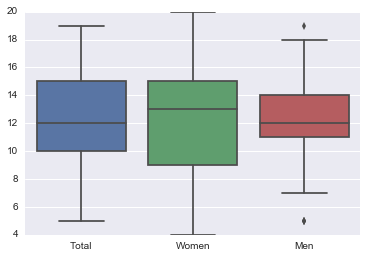

In [9]:
sns.boxplot(cleaned_df[["Total", "Women", "Men"]])

### The figure above depicts the distribution of educational life expectancy for women and men in the UN data. In these countries, men and women achieve an average of approximately 12 years of education. However, the boxplots above show the distributions of educational attainment differs. In this case, the median might actually be a comparator, which shows  that in half of these countries, women achieve 13 years of education or more while in half of them, men attain about one fewer year of education. Yet, there is a larger range of possible values among countries for women's education as well as much greater spread of data around the mean when compared to the distribution of years of education among these countries for men. 

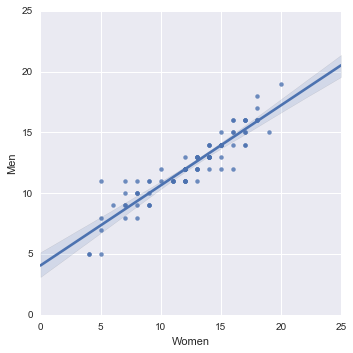

In [12]:
sns.lmplot('Women', 'Men', data=cleaned_df, fit_reg=True)

### The scatterplot above shows that there is a positive correlation between men's and women's educational life expectancy, suggesting that women and men achieve somewhat comparable levels of education within countries.

In [14]:
# GDP data
gdp_df = pd.read_csv('/Users/amybrown/Thinkful/Unit_3/Lesson_3/clean_gdp.csv', encoding='latin')   
gdp_df = gdp_df[gdp_df['1999'].notnull()]

In [15]:
### join GDP with cleaned_UN data
cleaned_df = cleaned_df.rename(columns={'Country or area': 'Country Name'})

keys = [c for c in gdp_df if c.startswith('19') or c.startswith('20')]
stacked = pd.melt(gdp_df, id_vars='Country Name',  value_vars=keys, value_name='key')
stacked = stacked.rename(columns={'variable': 'Year'})
stacked = stacked.rename(columns={'key': 'GDP'})

final_df = pd.merge(cleaned_df, stacked, on=['Country Name', 'Year'])

In [22]:
for col in final_df:
    print(col, final_df[col].dtypes) 

Country Name object
Year object
Total int64
Men int64
Women int64
GDP int64


## Education and GDP: is there a relationship? 

In [41]:
# first, use a log transformation on GDP
final_df['log_gdp'] = (np.log(final_df['GDP']))
x = (np.log(final_df['GDP']))
y = final_df['Total']

(0.47767316470368165, 2.8953679831667922e-05)

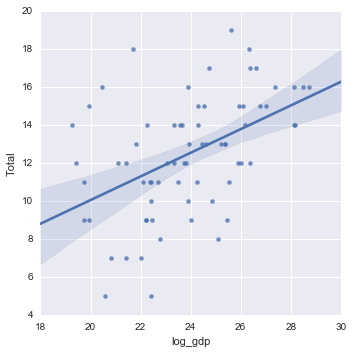

In [42]:
sns.lmplot('log_gdp', 'Total', data=final_df, fit_reg=True)
pearsonr(x, y)

### The scatterplot and correlation coefficient show there is a moderate positive relationship between total educational attainment and GDP. I think it would also be interesting to examine whether and how this relationship may change when looking specifically at the educational life expectancy for women versus for men.

(0.50280751758197695, 9.1723493825170222e-06)

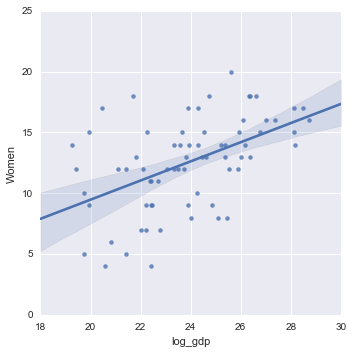

In [43]:
# Women
sns.lmplot('log_gdp', 'Women', data=final_df, fit_reg=True)
y = final_df['Women']
pearsonr(x, y)

(0.49471901228451071, 1.3410430327990812e-05)

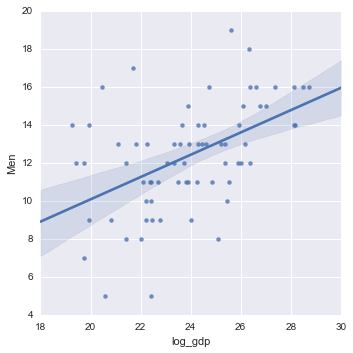

In [44]:
# Men
sns.lmplot('log_gdp', 'Men', data=final_df, fit_reg=True)
y = final_df['Men']
pearsonr(x, y)